# MISURE CON ARIA

In [55]:
import pandas as pd
import numpy as np
import os

dir_path = os.path.abspath('') #os.path.dirname(os.path.realpath(__file__))
FILE = dir_path + '/CSV/aria_dati_2.csv'
fr = pd.read_csv(FILE)

# m sta per media (valori aventi lo stesso flusso R)
# i valori medi sono stati calcolati con excel e occupano solo le prime 6 righe
p1 = np.array(fr['p1m'][:6]) * 1000 # kPa -> Pa
p2 = np.array(fr['p2m'][:6]) * 1000
p3 = np.array(fr['p3m'][:6]) * 1000
p4 = np.array(fr['p4m'][:6]) * 1000

# deviazioni standard
sp1 = np.array(fr['STD1'][:6]) * 1000
sp2 = np.array(fr['STD2'][:6]) * 1000
sp3 = np.array(fr['STD3'][:6]) * 1000
sp4 = np.array(fr['STD4'][:6]) * 1000

# offset per la pressione:
o1 = 0.249 * 1000
o2 = 0.166 * 1000
o3 = 0.198 * 1000
o4 = 0.300 * 1000

p1 = p1-o1
p2 = p2-o2
p3 = p3-o3
p4 = p4-o4

R = np.array(fr['Rm'][:6]) / 60000 # L/min litri per munuto -> m3/s

## calcolo velocità:

$R = cost = A_Lv_L = A_sv_s$

vL:  [ 4.18760469  5.4438861   6.7001675   7.95644891  9.21273032 10.46901173]
vs:  [18.43657817 23.96755162 29.49852507 35.02949853 40.56047198 46.09144543]


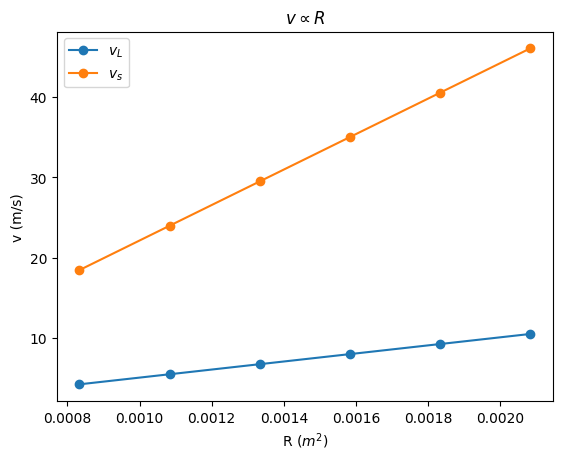

In [56]:
import matplotlib.pyplot as plt

AL = 1.99 / 10000 # m2
AS = 0.452 / 10000 # m2

vL = R / AL
vs = R / AS

print('vL: ',vL)
print('vs: ', vs)

plt.title('$v \propto R$')
plt.plot(R,vL,'o-', label='$v_L$')
plt.plot(R,vs,'o-', label='$v_s$')
plt.legend()
plt.xlabel('R ($m^2$)')
plt.ylabel('v (m/s)')
plt.show()

### VALORI DI PRESSIONE RACCOLTI

all'interno del tubo si verificano fenomeni di turbolenza che alterano il valore della pressione tra P1-P3 e P2-P4.

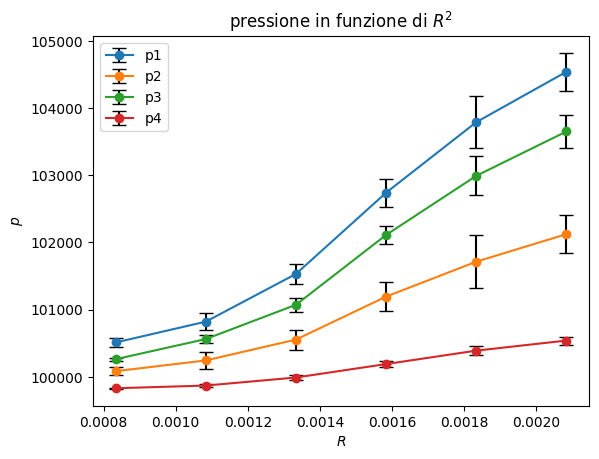

In [57]:
plt.title('pressione in funzione di $R^2$')
plt.errorbar(R,p1,fmt='o-',yerr=sp1,capsize=5, ecolor='black',label='p1')
plt.errorbar(R,p2,fmt='o-',yerr=sp1,capsize=5, ecolor='black',label='p2')
plt.errorbar(R,p3,fmt='o-',yerr=sp3,capsize=5, ecolor='black',label='p3')
plt.errorbar(R,p4,fmt='o-',yerr=sp4,capsize=5, ecolor='black',label='p4')
plt.xlabel('$R$')
plt.ylabel('$p$')
plt.legend()
plt.show()

Applichiamo le correzioni ai valori delle pressioni causati dalle turbolenze:

$P_L = P_1 \\$
$P_s = p_2 + \Delta P = P_2 + \frac{(P_1 - P_3)}{2} \\$
$P_L - P_s = P_1 - P_2 - \Delta P \\$

In [58]:
from interpolazione3 import final_val

pL, spL = p1, sp1

ps = p2 + ((p1) - (p3))/2
sps = np.sqrt((sp2)**2 + (0.5 * sp1)**2 + (0.5*sp3)**2) # usando derivate parziali

PLPs, sPLPs = pL - ps, np.sqrt(spL**2 + sps**2)

print('pL: ',final_val(pL,spL))
print('ps:',final_val(ps,sps))
print('pL-ps: ',final_val(PLPs,sPLPs))


pL:  [100511. 100821. 101531. 102741. 103791. 104541.] ± [ 60. 130. 150. 210. 390. 280.] 
ps: [100208.5 100373.5 100783.5 101508.5 102113.5 102568.5] ± [ 59.16  87.32 103.08 137.3  280.45 231.52] 
pL-ps:  [ 302.5  447.5  747.5 1232.5 1677.5 1972.5] ± [ 84.26 156.6  182.   250.9  480.36 363.32] 


## Verifica con equzione di Bernoulli:

$p_L - p_s = \frac{1}{2}\rho(v_s^2-v_L^2) = \frac{1}{2}\rho R^2 (\frac{1}{A_s^2} - \frac{1}{A_L^2})$

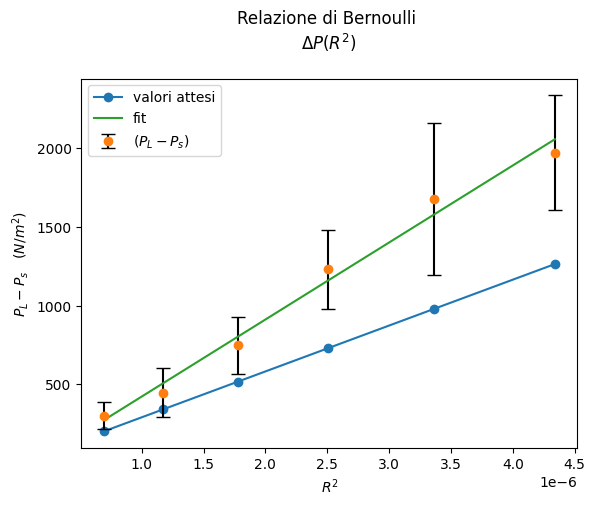


linearità A + BX
    
A: -65.93379851895406 
B: 489066066.0506614
sigmaA: 110.85748330718874
sigmaB: 42182370.051419236

sigmaY: [ 84.26149773 156.60459763 182.00274723 250.89838581 480.36444498
 363.31804249]    
chiquadro ridotto: 0.14
df: 4
pvalue: 99.8%
--------------------------------------------------
chi2o:  3.388562630599821
pvalue:  49.5 %


In [63]:
from interpolazione3 import RettaInterpolata
import scipy.stats as sc

rho = 1.255 # Kg/m3 densità dell'aria
R2 = R**2
p_attesi = 0.5 * rho * (vs**2 - vL**2)

r = RettaInterpolata(R2,PLPs,sPLPs)

plt.title("Relazione di Bernoulli \n$\Delta P(R^2)$ \n")
plt.plot(R2,p_attesi,'o-',label='valori attesi')
plt.errorbar(R2,PLPs,fmt='o',yerr=sPLPs,capsize=5, ecolor='black',label='$(P_L - P_s)$')
plt.plot(r.x_best,r.y_best,label='fit')
plt.xlabel('$R^2$')
plt.ylabel('$P_L - P_s \quad (N / m^2)$')
plt.legend()
plt.show()

print(r)

# chiquadro e verifica adattamento dati

y = r.A + r.B * R2 # uso i valori sulla retta interpolata
chi = np.sum(((p_attesi - y)/sPLPs)**2)
df = len(R2) - 2
rchi = chi / df

print('--------------------------------------------------')
print('chi2o: ', rchi)
print('pvalue: ',np.round(sc.chi2.sf(rchi,df)*100,1),'%')
